load module


In [3]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as k
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
import seaborn as sns
from keras.layers import Dropout
import nltk
import ssl
from nltk.tokenize import word_tokenize
from keras.regularizers import l2




load dataset

In [4]:
sentimen = pd.read_csv('train_preprocess.tsv.txt', sep="\t", names=["teks", "label"])
sentimen

,teks,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [5]:
#cek 5 dataset teraatas
sentimen.head()


,teks,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [6]:
#cek 5 dataset terbawah
sentimen.tail()

,teks,label
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative
10999,meskipun sering belanja ke yogya di riau junct...,positive


In [7]:
#mengetahui isi data set
sentimen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [8]:
#mengetahui nilai yg hilang
sentimen.isna

<bound method DataFrame.isna of                                                     teks     label
0      warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1      mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2      lokasi strategis di jalan sumatera bandung . t...  positive
3      betapa bahagia nya diri ini saat unboxing pake...  positive
4      duh . jadi mahasiswa jangan sombong dong . kas...  negative
...                                                  ...       ...
10995                                       tidak kecewa  positive
10996  enak rasa masakan nya apalagi kepiting yang me...  positive
10997        hormati partai-partai yang telah berkoalisi   neutral
10998  pagi pagi di tol pasteur sudah macet parah , b...  negative
10999  meskipun sering belanja ke yogya di riau junct...  positive

[11000 rows x 2 columns]>

In [9]:
#mengetahui nilai yg hilang
sentimen.isna().sum()

teks     0
label    0
dtype: int64

In [10]:
#mengetahui jumlah  data yang akan diproses
sentimen.shape

(11000, 2)

cleansing

In [11]:
#perintah cleansning
def cleansing(teks):
     string = teks.lower() #mengubah huruf kapital menjadi huruf kecil
     string = re.sub(r'\burl\b', '', string) #menghilangkan kata URL 
     string = re.sub(r'\\[^\s]+', '', string) #menghilankan kata yang dimulai dengan \
     #string = re.sub(r'rt|wk|[^\w\s]', '', string) #menghilangkan kata wkwkwkw
     string = re.sub(r'[^a-zA-Z0-9]', ' ', string) #remove selain huruf
     #string = re.sub(r'rt|user|[^\w\s]', '', string) #remove kata usename dan dan kata selanjutnya
     string = re.sub(r'\d', '', string) # remove number
     string = re.sub(r'\b\w\b', '', string) #menghilangkan huruf tunggal
     string = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ', string) #remove link url
     string = re.sub('  +', ' ', string) # Remove extra space
     string = re.sub(r'[^\w\s]', '', string)
     return string

In [12]:
#melihat hasil cleansing
sentimen = pd.read_csv('train_preprocess.tsv.txt', sep="\t", names=["teks", "label"])
sentimen = sentimen['teks'].apply(cleansing)
sentimen

0        warung ini dimiliki oleh pengusaha pabrik tahu...
1        mohon ulama lurus dan mmbri hujjah partai apa ...
2        lokasi strategis di jalan sumatera bandung tem...
3        betapa bahagia nya diri ini saat unboxing pake...
4        duh jadi mahasiswa jangan sombong dong kasih k...
                               ...                        
10995                                         tidak kecewa
10996    enak rasa masakan nya apalagi kepiting yang me...
10997          hormati partai partai yang telah berkoalisi
10998    pagi pagi di tol pasteur sudah macet parah bik...
10999    meskipun sering belanja ke yogya di riau junct...
Name: teks, Length: 11000, dtype: object

In [13]:
#penambahan hasil cleansing ke kolom baru
sentimen = pd.read_csv('train_preprocess.tsv.txt', sep="\t", names=["teks", "label"])
sentimen['teks cleansing'] = sentimen['teks'].apply(cleansing)
sentimen

,teks,label,teks cleansing
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan mmbri hujjah partai apa ...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...
...,...,...,...
10995,tidak kecewa,positive,tidak kecewa
10996,enak rasa masakan nya apalagi kepiting yang me...,positive,enak rasa masakan nya apalagi kepiting yang me...
10997,hormati partai-partai yang telah berkoalisi,neutral,hormati partai partai yang telah berkoalisi
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi pagi di tol pasteur sudah macet parah bik...


In [14]:
#cek dataset duplikat
sentimen.duplicated().sum()


67

In [15]:
#hapus dataset duplikat
sentimen = sentimen.drop_duplicates()


In [16]:
#cek kembali dataset duplikat
sentimen.duplicated().sum()

0

In [17]:
#cek dataset yang akan diproses setelah menghilangkan duplikat
sentimen.shape

(10933, 3)

In [19]:
#simpan sebagai datasetbaru sesudah cleansing dan hapus duplikat
sentimen.to_csv('sentimen.csv')

In [20]:
#load data kembali untuk proses training
df = pd.read_csv('sentimen.csv')
df

,Unnamed: 0,teks,label,teks cleansing
0,0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan mmbri hujjah partai apa ...
2,2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...
3,3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...
...,...,...,...,...
10928,10993,f - demokrat dorong upaya kemandirian energi n...,neutral,demokrat dorong upaya kemandirian energi nasi...
10929,10994,tidak bosan,positive,tidak bosan
10930,10996,enak rasa masakan nya apalagi kepiting yang me...,positive,enak rasa masakan nya apalagi kepiting yang me...
10931,10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative,pagi pagi di tol pasteur sudah macet parah bik...


In [21]:
#hapus kolom yang tidak perlu
df = df.drop('teks', axis=1)
df

,Unnamed: 0,label,teks cleansing
0,0,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,1,neutral,mohon ulama lurus dan mmbri hujjah partai apa ...
2,2,positive,lokasi strategis di jalan sumatera bandung tem...
3,3,positive,betapa bahagia nya diri ini saat unboxing pake...
4,4,negative,duh jadi mahasiswa jangan sombong dong kasih k...
...,...,...,...
10928,10993,neutral,demokrat dorong upaya kemandirian energi nasi...
10929,10994,positive,tidak bosan
10930,10996,positive,enak rasa masakan nya apalagi kepiting yang me...
10931,10998,negative,pagi pagi di tol pasteur sudah macet parah bik...


In [22]:

#hapus kolom yang tidak perlu
df = df.drop('Unnamed: 0', axis=1)
df

,label,teks cleansing
0,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,neutral,mohon ulama lurus dan mmbri hujjah partai apa ...
2,positive,lokasi strategis di jalan sumatera bandung tem...
3,positive,betapa bahagia nya diri ini saat unboxing pake...
4,negative,duh jadi mahasiswa jangan sombong dong kasih k...
...,...,...
10928,neutral,demokrat dorong upaya kemandirian energi nasi...
10929,positive,tidak bosan
10930,positive,enak rasa masakan nya apalagi kepiting yang me...
10931,negative,pagi pagi di tol pasteur sudah macet parah bik...


In [23]:
#cek kategori dataset
count_label = df.groupby('label').label.count()
count_label

label
negative    3412
neutral     1138
positive    6383
Name: label, dtype: int64

<Axes: ylabel='label'>

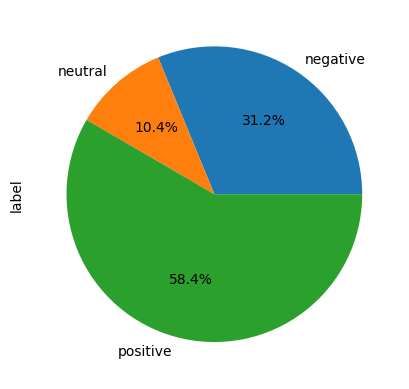

In [24]:
#visualisasi distribusi dataset
count_label.plot(kind='pie', autopct='%1.1f%%')

In [25]:
#cek kata yg sering muncul
text = ' '.join(df['teks cleansing'])
wordcloud = WordCloud().generate(text)

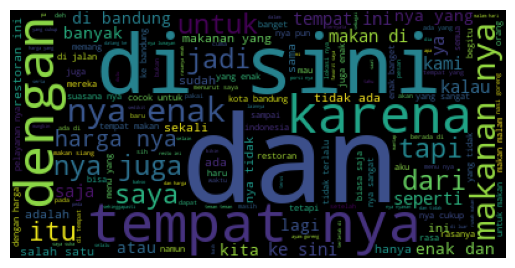

In [26]:
#kata yang sering muncul dari seluruh dataset
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

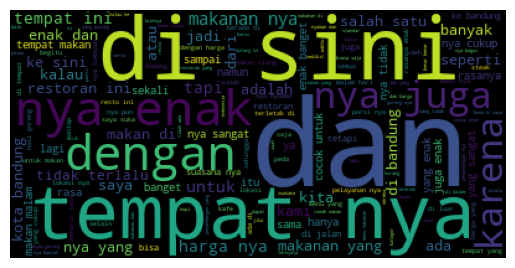

In [27]:
#kata yang sering muncul dari dataset yang berlabel positive
text_positive = ' '.join(df['teks cleansing'][df.label=="positive"])
wordcloud_positive = WordCloud().generate(text_positive)
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.show()

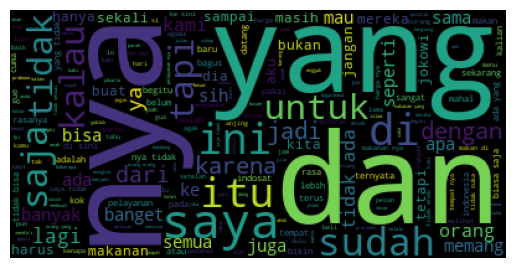

In [28]:
#kata yang sering muncul dari dataset yang berlabel negative
text_positive = ' '.join(df['teks cleansing'][df.label=="negative"])
wordcloud_positive = WordCloud().generate(text_positive)
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.show()

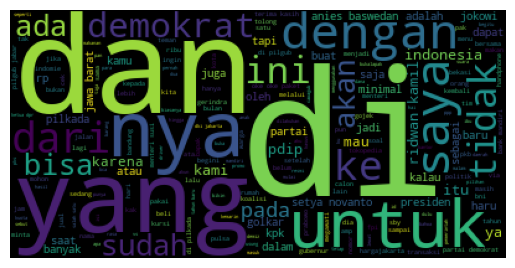

In [29]:
##kata yang sering muncul dari dataset yang berlabel neutral
text_positive = ' '.join(df['teks cleansing'][df.label=="neutral"])
wordcloud_positive = WordCloud().generate(text_positive)
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.show()

In [30]:
#tokenizer
def word_tokenize_wrapper(text):
    return word_tokenize(text)

In [31]:
#buat kolom baru hasil tokenizer
df['Teks_Token'] = df['teks cleansing'].apply(word_tokenize_wrapper)
df

,label,teks cleansing,Teks_Token
0,positive,warung ini dimiliki oleh pengusaha pabrik tahu...,"[warung, ini, dimiliki, oleh, pengusaha, pabri..."
1,neutral,mohon ulama lurus dan mmbri hujjah partai apa ...,"[mohon, ulama, lurus, dan, mmbri, hujjah, part..."
2,positive,lokasi strategis di jalan sumatera bandung tem...,"[lokasi, strategis, di, jalan, sumatera, bandu..."
3,positive,betapa bahagia nya diri ini saat unboxing pake...,"[betapa, bahagia, nya, diri, ini, saat, unboxi..."
4,negative,duh jadi mahasiswa jangan sombong dong kasih k...,"[duh, jadi, mahasiswa, jangan, sombong, dong, ..."
...,...,...,...
10928,neutral,demokrat dorong upaya kemandirian energi nasi...,"[demokrat, dorong, upaya, kemandirian, energi,..."
10929,positive,tidak bosan,"[tidak, bosan]"
10930,positive,enak rasa masakan nya apalagi kepiting yang me...,"[enak, rasa, masakan, nya, apalagi, kepiting, ..."
10931,negative,pagi pagi di tol pasteur sudah macet parah bik...,"[pagi, pagi, di, tol, pasteur, sudah, macet, p..."


In [33]:

#menghilangkan stop word dan di buat kolom baru
list_stopwords = stopwords.words('indonesian')
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       'user', 'bukan', 'hanya', 'kata', 'gua', '&amp', 'yah',
                       'orang', 'lu', 'url', 'gue', 'tp', 'gw', 'udah', 'lo', 'url',
                       'dah', 'jg', 'org', 'emang', 'pake', 'no',
                       'pa','ni','mah','iya','bgt','tu','gk','liat','mas','cak'
                       '&amp', 'yah', 'g', 'nggak', 'nda', 'ke', 'pas', 'dan',
                       'dengan', 'di', 'sini'])

list_stopwords = set(list_stopwords)
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

df["Text_Remove_Stopwords"]= df['Teks_Token'].apply(stopwords_removal)

df["Text_Remove_Stopwords"]= df["Text_Remove_Stopwords"].str.join(sep=" ")

df

,label,teks cleansing,Teks_Token,Text_Remove_Stopwords
0,positive,warung ini dimiliki oleh pengusaha pabrik tahu...,"[warung, ini, dimiliki, oleh, pengusaha, pabri...",warung dimiliki pengusaha pabrik puluhan terke...
1,neutral,mohon ulama lurus dan mmbri hujjah partai apa ...,"[mohon, ulama, lurus, dan, mmbri, hujjah, part...",mohon ulama lurus mmbri hujjah partai diwlh su...
2,positive,lokasi strategis di jalan sumatera bandung tem...,"[lokasi, strategis, di, jalan, sumatera, bandu...",lokasi strategis jalan sumatera bandung nyaman...
3,positive,betapa bahagia nya diri ini saat unboxing pake...,"[betapa, bahagia, nya, diri, ini, saat, unboxi...",betapa bahagia unboxing paket barang bagus men...
4,negative,duh jadi mahasiswa jangan sombong dong kasih k...,"[duh, jadi, mahasiswa, jangan, sombong, dong, ...",duh mahasiswa sombong kasih kartu kuning belaj...
...,...,...,...,...
10928,neutral,demokrat dorong upaya kemandirian energi nasi...,"[demokrat, dorong, upaya, kemandirian, energi,...",demokrat dorong upaya kemandirian energi nasional
10929,positive,tidak bosan,"[tidak, bosan]",bosan
10930,positive,enak rasa masakan nya apalagi kepiting yang me...,"[enak, rasa, masakan, nya, apalagi, kepiting, ...",enak masakan kepiting menyenangkan memilih kep...
10931,negative,pagi pagi di tol pasteur sudah macet parah bik...,"[pagi, pagi, di, tol, pasteur, sudah, macet, p...",pagi pagi tol pasteur macet parah jengkel


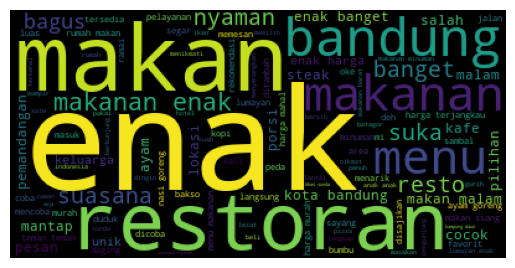

In [34]:
#kata yang sering muncul dari dataset yang berlabel positive setelah tokenizer
text_positive = ' '.join(df['Text_Remove_Stopwords'][df.label=="positive"])
wordcloud_positive = WordCloud().generate(text_positive)
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.show()

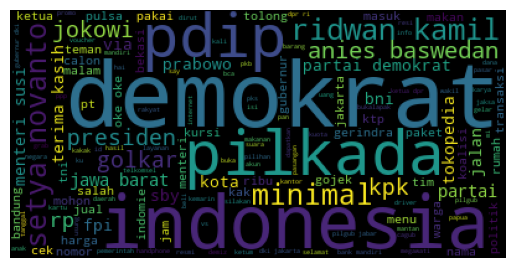

In [35]:
#kata yang sering muncul dari dataset yang berlabel neutral setelah tokenizer

text_neutral = ' '.join(df['Text_Remove_Stopwords'][df.label=="neutral"])
wordcloud_neutral = WordCloud().generate(text_neutral)
plt.imshow(wordcloud_neutral)
plt.axis("off")
plt.show()

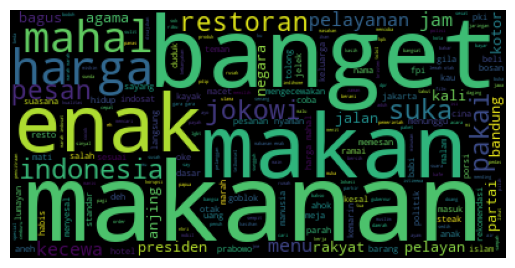

In [36]:
#kata yang sering muncul dari dataset yang berlabel negative setelah tokenizer

text_negative = ' '.join(df['Text_Remove_Stopwords'][df.label=="negative"])
wordcloud_negative= WordCloud().generate(text_negative)
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.show()

In [37]:
# sortir data masing-masing data label
neg = df.loc[df['label'] == 'negative']['Text_Remove_Stopwords'].tolist()
neu = df.loc[df['label'] == 'neutral']['Text_Remove_Stopwords'].tolist()
pos = df.loc[df['label'] == 'positive']['Text_Remove_Stopwords'].tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral']. label.tolist()
pos_label = df.loc[df['label'] == 'positive']. label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('positive: %s, neutral: %s, negative: %s' % (len(pos), len(neu), len(neg)))
print('total data: %s' % len(total_data))

positive: 6383, neutral: 1138, negative: 3412
total data: 10933


<Axes: ylabel='label'>

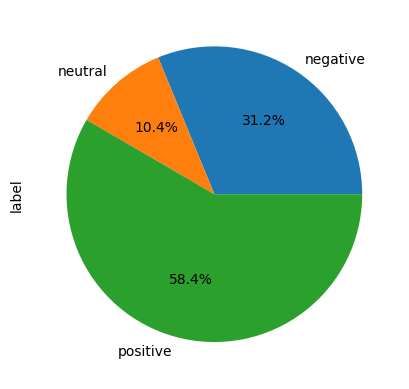

In [38]:
#distribusi label
count_label = df.groupby('label').label.count()
count_label
count_label.plot(kind='pie', autopct='%1.1f%%')

LSTM

In [39]:
#buat tokenizer pickle
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ' , lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('tokenizer.pickle successfully')

tokenizer.pickle successfully


In [40]:
#panggil modul tokenizer / feature extraction
X = tokenizer.texts_to_sequences(total_data)

#panggil modul pad sequence / ubah vector/array bentuk 2d
vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)
maxlen

52

In [41]:
#lihat isi x setelah di ubah
df_array = pd.DataFrame(data=X)
print(df_array)

           0       1       2       3        4       5       6       7   \
0       115.0  2199.0  3313.0  2945.0   1024.0   119.0   357.0     6.0   
1        27.0   126.0    12.0  1668.0      6.0    11.0   583.0   140.0   
2      3821.0  1240.0  8103.0   173.0    177.0    16.0  4569.0    93.0   
3         2.0   105.0     4.0     2.0    433.0  3822.0   719.0     9.0   
4        65.0    16.0   109.0     2.0      1.0  1059.0    43.0    99.0   
...       ...     ...     ...     ...      ...     ...     ...     ...   
10928   361.0  4073.0    30.0   920.0    613.0   376.0  4473.0  1295.0   
10929   883.0   137.0     7.0  1481.0  16216.0   516.0   211.0  3582.0   
10930  1850.0  2325.0    20.0    28.0   6582.0     6.0    77.0   807.0   
10931  5577.0  4347.0     NaN     NaN      NaN     NaN     NaN     NaN   
10932   168.0   168.0   641.0   885.0    209.0   409.0  2528.0     NaN   

           8       9   ...  42  43  44  45  46  47  48  49  50  51  
0       494.0  1486.0  ... NaN NaN NaN NaN

In [43]:
#panggil modul pad sequence 
X = pad_sequences(X)

with open('x_pad_sequences.pickle','wb') as handle:
    pickle.dump(X, handle, protocol = pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle telah berhasil dibuat bos!")

x_pad_sequences.pickle telah berhasil dibuat bos!


In [44]:
#melihat array pad sequence
X

array([[   0,    0,    0, ...,  282,  256, 8102],
       [   0,    0,    0, ..., 5757,    1,    1],
       [   0,    0,    0, ...,   16, 4569,   93],
       ...,
       [   0,    0,    0, ...,  625, 6159,   36],
       [   0,    0,    0, ...,    0, 5577, 4347],
       [   0,    0,    0, ...,  209,  409, 2528]], dtype=int32)

In [45]:
#lihat array
df_array = pd.DataFrame(data=X)
print(df_array)

       0   1   2   3   4   5   6   7   8   9   ...   42    43    44    45  \
0       0   0   0   0   0   0   0   0   0   0  ...   14   197    39     4   
1       0   0   0   0   0   0   0   0   0   0  ...  140  5756     1   401   
2       0   0   0   0   0   0   0   0   0   0  ...    0     0  3821  1240   
3       0   0   0   0   0   0   0   0   0   0  ...    4     2   433  3822   
4       0   0   0   0   0   0   0   0   0   0  ...    5    40     2    97   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   
10928   0   0   0   0   0   0   0   0   0   0  ...    0   361  4073    30   
10929   0   0   0   0   0   0   0   0   0   0  ...  883   137     7  1481   
10930   0   0   0   0   0   0   0   0   0   0  ...    6    77   807   164   
10931   0   0   0   0   0   0   0   0   0   0  ...    0     0     0     0   
10932   0   0   0   0   0   0   0   0   0   0  ...    0     0     0   168   

          46    47    48    49    50    51  
0         54  2396  8101   282

In [46]:
# feature extraction
# memanggil modul tokenizer
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

# memanggil modul pad sequences
X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('x_pad_sequences.pickle sudah dibuat boss')

x_pad_sequences.pickle sudah dibuat boss


In [48]:
#memasukan label ke variabel Y
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('y_labels.pickle sudah dibuat boss')

Y = pad_sequences(Y)


y_labels.pickle sudah dibuat boss


In [49]:
#lihat isi dari labels
labels

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',

In [50]:
#lihat bentuk Y
Y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=int32)

In [52]:
#lihat isi Y
df_array = pd.DataFrame(data=Y)
print(df_array)

       0  1  2
0      0  0  1
1      0  0  1
2      0  0  1
3      0  0  1
4      0  0  1
...   .. .. ..
10928  1  0  0
10929  1  0  0
10930  1  0  0
10931  1  0  0
10932  1  0  0

[10933 rows x 3 columns]


In [53]:
#training dataset
file = open('x_pad_sequences.pickle', 'rb')
X = pickle.load(file)
file.close()

In [54]:
# menyimpan data teks picle
file = open('y_labels.pickle', 'rb')
Y = pickle.load(file)
file.close()

In [55]:
# membagi (split) data set train 80% test 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [56]:
#LSTM MODEL
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate = 0.0001)
model.compile(loss= 'categorical_crossentropy', optimizer= adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 52, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
875/875 [==============================] - 24s 26ms/step - loss: 0.7561 - accuracy: 0.6900 - val_loss: 0.6253 - val_accuracy: 0.7577
Epoch 2/10
875/875 [==============================] - 26s 30ms/step - loss: 0.5582 - accuracy: 0.7721 - val_loss: 0.5348 - val_ac

In [57]:
#hasil training
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('testing sudah selesai')
print(matrix_test)

69/69 [==============================] - 1s 5ms/step
testing sudah selesai
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       668
           1       0.78      0.69      0.73       231
           2       0.93      0.88      0.91      1288

    accuracy                           0.85      2187
   macro avg       0.82      0.81      0.81      2187
weighted avg       0.86      0.85      0.85      2187



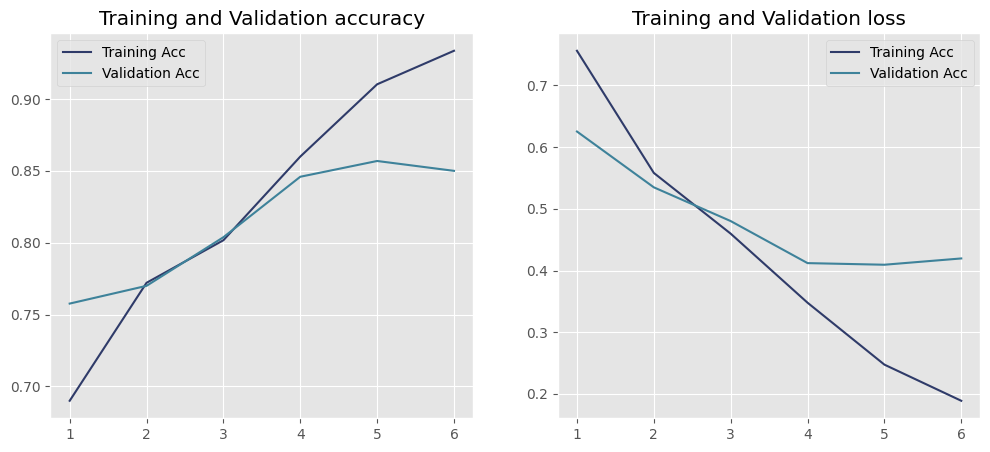

In [58]:
#visualisasi hasil training
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, '#2F3B69', label='Training Acc')  # Warna '#2F3B69' untuk training accuracy
    plt.plot(x, val_acc, '#3E829A', label='Validation Acc')  # Warna
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, '#2F3B69', label='Training Acc')  # Warna '#2F3B69' untuk training accuracy
    plt.plot(x, val_loss, '#3E829A', label='Validation Acc')  # Warna
    plt.title('Training and Validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [59]:
#cross validasi
kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train    = X[data[0]]
    target_train  = y[data[0]]

    data_test     = X[data[1]]
    target_test   = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    print(model.summary())

    adam = optimizers.legacy.Adam(learning_rate = 0.0001)
    model.compile(loss= 'categorical_crossentropy', optimizer= adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])


    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print('training ke ', iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print('==============================================================')

    accuracies.append(accuracy)


#average_accuracy = np.mean(accuracies)

print()
print()
print()
#print('rata-rata Acuracy:', average_accuracy)

    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 52, 100)           10000000  
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
875/875 [==============================] - 24s 27ms/step - loss: 0.7667 - accuracy: 0.6871 - val_loss: 0.6277 - val_accuracy: 0.7595
Epoch 2/10
875/875 [==============================] - 24s 27ms/step - loss: 0.5568 - accuracy: 0.7757 - val_loss: 0.5313 - val_

In [61]:
#melihat rata-rata cross validation
average_accuracy = np.mean(accuracies)
print('rata-rata Acuracy:', average_accuracy)

rata-rata Acuracy: 0.8462734339277549


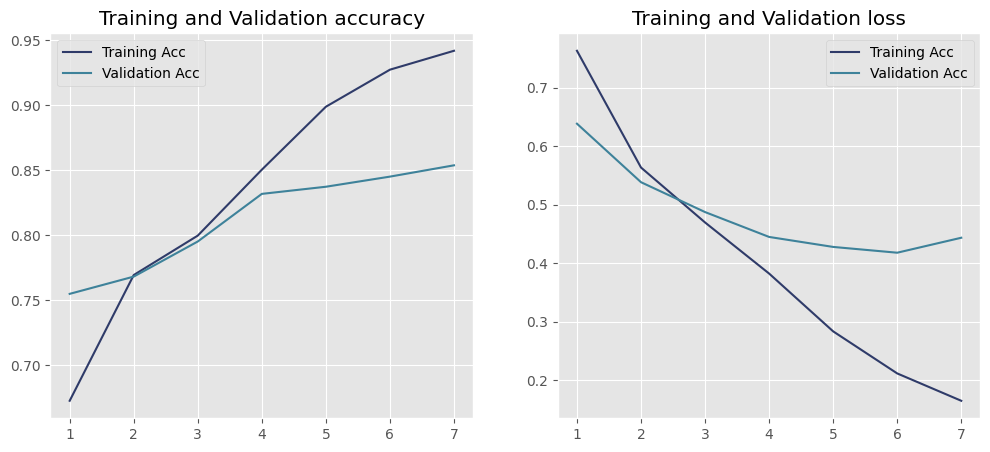

In [62]:
#visualisasi cross validation
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, '#2F3B69', label='Training Acc')  # Warna '#2F3B69' untuk training accuracy
    plt.plot(x, val_acc, '#3E829A', label='Validation Acc')  # Warna
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, '#2F3B69', label='Training Acc')  # Warna '#2F3B69' untuk training accuracy
    plt.plot(x, val_loss, '#3E829A', label='Validation Acc')  # Warna
    plt.title('Training and Validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [64]:
#simpan model
model.save('model fit lstmfix-1.h5')
print('model created succsessfuly boss')

model created succsessfuly boss


In [65]:
# testing data baru
input_text = """indonesia indah sekali"""

def cleansing(sent):

    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]',' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model fit lstmfix-1.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('text: ',text[0])
print('sentiment: ',sentiment[polarity])


1/1 [==============================] - 0s 154ms/step
text:  indonesia indah sekali
sentiment:  positive
